# Sentiment analysis for the World Cup being held in Qatar

## Installing required libraries

In [2]:
!pip install transformers -qq
!pip install torchtext -qq
!pip install twint -qq
!pip install --user --upgrade "git+https://github.com/twintproject/twint.git@origin/master#egg=twint" -qq
!pip install nest_asyncio -qq
!pip install emot --upgrade -qq

## Scraping Twitter for tweets about the World Cup in Qatar

In [3]:
import twint
import pandas
import nest_asyncio

nest_asyncio.apply()
c = twint.Config()
c.Store_object = True
c.Pandas = True
c.Search = "world cup qatar"
c.Limit = 100000
c.Since = "2022-01-01"
c.Until = "2022-09-24" 
c.Lang = "en"
c.Hide_output = True
twint.run.Search(c)

df = twint.storage.panda.Tweets_df

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


## Data preprocessing

### Removing hashtags

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download("stopwords")

# removing hashtags
def hashtags(text):
  hash = re.findall(r"#(\w+)", text)
  return hash

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Translating emojis

In [5]:
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

# translating emoji
def emoji(text):
  for emot in UNICODE_EMOJI:
    if text == None:
      text = text
    else:
      text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()))
    return text

### Removing usernames

In [6]:
# removing retweet username and tweeted at @username
def remove_users(tweet):
  tweet = re.sub("(@[A-Za-z]+[A-Za-z0-9-_]+)", "", tweet)
  return tweet

### Removing hyperlinks

In [7]:
# removing links
def remove_links(tweet):
  tweet = re.sub(r"http\S+", "", tweet) # remove http links
  tweet = re.sub(r"bit.ly/\S+", "", tweet) # remove bitly links
  tweet = tweet.strip("[link]") # remove [links]
  return tweet
def clean_html(text):
  html = re.compile("<.*?>")#regex
  return html.sub(r"",text)

### Removing Non-ASCII characters

In [8]:
# removing non ascii character
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def lower(text):
  return text.lower()

### Removing email addresses and punctuation

In [9]:
# removing email address
def email_address(text):
  email = re.compile(r"[\w\.-]+@[\w\.-]+")
  return email.sub(r"",text)

def punct(text):
  token = RegexpTokenizer(r"\w+")
  text = token.tokenize(text)
  text= " ".join(text)
  return text 

### Removing stopwords

In [10]:
# remove stopwords
def removeStopWords(str):
  cachedStopWords = set(stopwords.words("english"))
  cachedStopWords.update(("and", "I", "A", "http", "And", "So", "arent", "This", "When", "It", "many", "Many",
                          "so", "cant", "Yes", "yes", "No", "no", "These", "these", "mailto", "regards", "like", "email"))
  new_str = "" "".join([word for word in str.split() if word not in cachedStopWords]) 
  return new_str

### Removing special characters

In [11]:
def remove_(tweet):
  tweet = re.sub("([_]+)", "", tweet)
  return tweet

### Applying preprocessing to the data

In [12]:
df["hashtag"] = df.tweet.apply(func = hashtags)
df["new_tweet"] = df.tweet.apply(func = emoji)
df["new_tweet"] = df.new_tweet.apply(func = remove_users)
df["new_tweet"] = df.new_tweet.apply(func = clean_html)
df["new_tweet"] = df.new_tweet.apply(func = remove_links)
df["new_tweet"] = df.new_tweet.apply(func = non_ascii)
df["new_tweet"] = df.new_tweet.apply(func = lower)
df["new_tweet"] = df.new_tweet.apply(func = email_address)
df["new_tweet"] = df.new_tweet.apply(func = removeStopWords)
df["new_tweet"] = df.new_tweet.apply(func = clean_html)
df["new_tweet"] = df.new_tweet.apply(func = punct)
df["new_tweet"] = df.new_tweet.apply(func = remove_)

## Sentiment classification using the pretrained twitter weights

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", from_tf = True)

def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors = "pt")
  result = model(tokens)
  return int(torch.argmax(result.logits))

df["sentiment"] = df["new_tweet"].apply(lambda x: sentiment_score(x[:512]))
df = df[["hashtag", "tweet", "new_tweet", "sentiment"]]
df["sentiment"] = np.where(df["sentiment"] == 0, "negative", np.where(df["sentiment"] == 1, "neutral", "positive"))
df.to_csv("tweets.csv")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Frequency table for sentiment classification

negative    14704
positive      822
neutral       364
Name: sentiment, dtype: int64


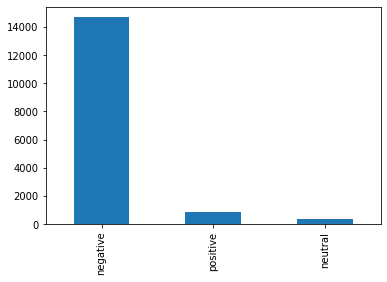

In [15]:
print(df["sentiment"].value_counts())
df["sentiment"].value_counts().plot.bar()

### Top 20 most frequently used hashtags

boycottqatar2022           68.0
sports                     70.0
england                    74.0
thetrndshop                74.0
footballworldcup           82.0
usavjpn                    84.0
japan                      86.0
usa                        95.0
doha                      117.0
soccer                    120.0
fifaworldcupqatar2022     121.0
usmnt                     133.0
canmnt                    151.0
football                  252.0
fifa                      304.0
fifaworldcup              386.0
worldcup2022              387.0
worldcup                  879.0
qatar2022                 920.0
qatar                    1174.0
dtype: float64


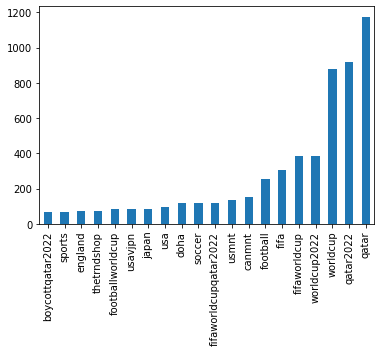

In [55]:
hash_tags = df["hashtag"]
hash_tags = hash_tags.apply(lambda x: ", ".join(dict.fromkeys(x).keys()))
hash_tags = hash_tags[hash_tags != ""]
hash_tags = hash_tags.str.lower()
hash_tags = hash_tags.str.split(',\s+').apply(lambda x: pandas.Series(x).value_counts()).sum()
hash_tags = hash_tags.sort_values()[-20:]
print(hash_tags)
hash_tags.plot.bar()